# 4.2 - Convolutional Neural Networks

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
%matplotlib inline

/opt/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Image analytics tasks

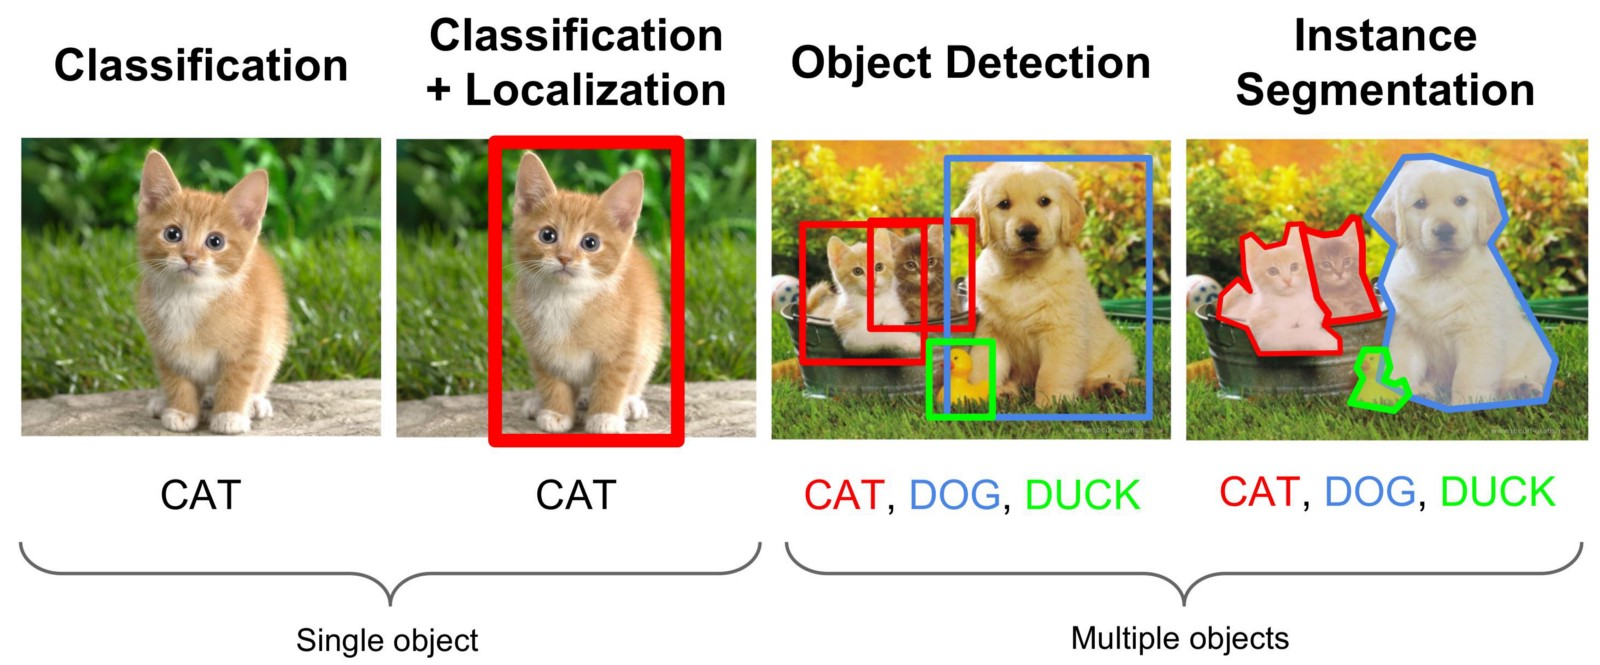

In [2]:
from IPython.display import Image
Image(filename='local/imgs/imgs_tasks.jpeg', width=800)

### Explore [COCO Dataset](http://cocodataset.org/)

**also**

- Image APIs [Clarifai](https://clarifai.com/demo) [Amazon Rekognition](https://aws.amazon.com/rekognition/), [Google Cloud Vision](https://cloud.google.com/vision/docs/drag-and-drop)
- Image Captioning (con CNN + RNN!!!) [caption bot](https://www.captionbot.ai/)



## Convolutional Neural Networks

see https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd

see [filter activation demo](http://ml4a.github.io/demos/convolution_all/) [confusion matrix](http://ml4a.github.io/demos/confusion_cifar/)

see [The 9 Deep Learning Papers You Should Know](https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)

### RECOMMENDATION

- close all applications
- install Maxthon browser http://www.maxthon.com
- open only VirtualBox and Maxthon


## First level filters and activations maps

the filters in the middle  are applied to the image on the left. Observe, for instance, in what parts of the image the seventh filter of the first row is activated (the one before the last one in the first row).

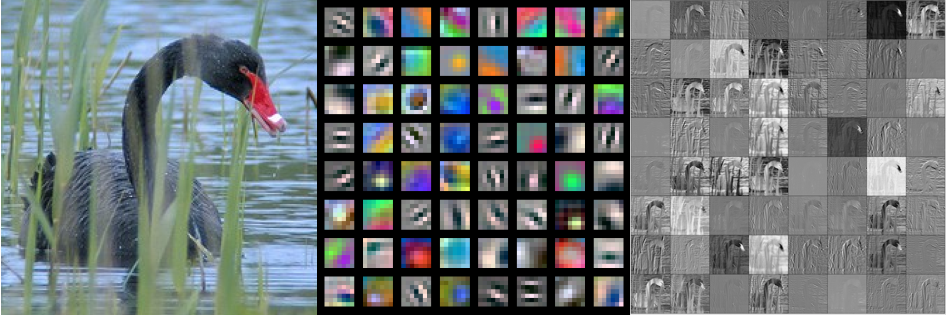

In [3]:
Image(filename='local/imgs/cnn_swan.png', width=800)

## Hierarchy of filters and activation maps

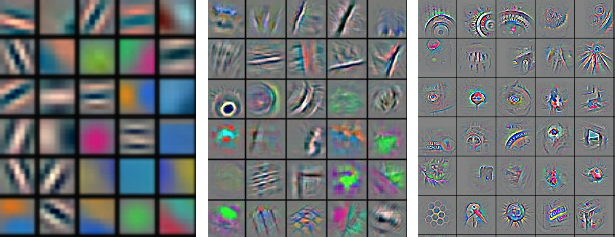

In [4]:
Image(filename='local/imgs/cnn_features.png', width=600)

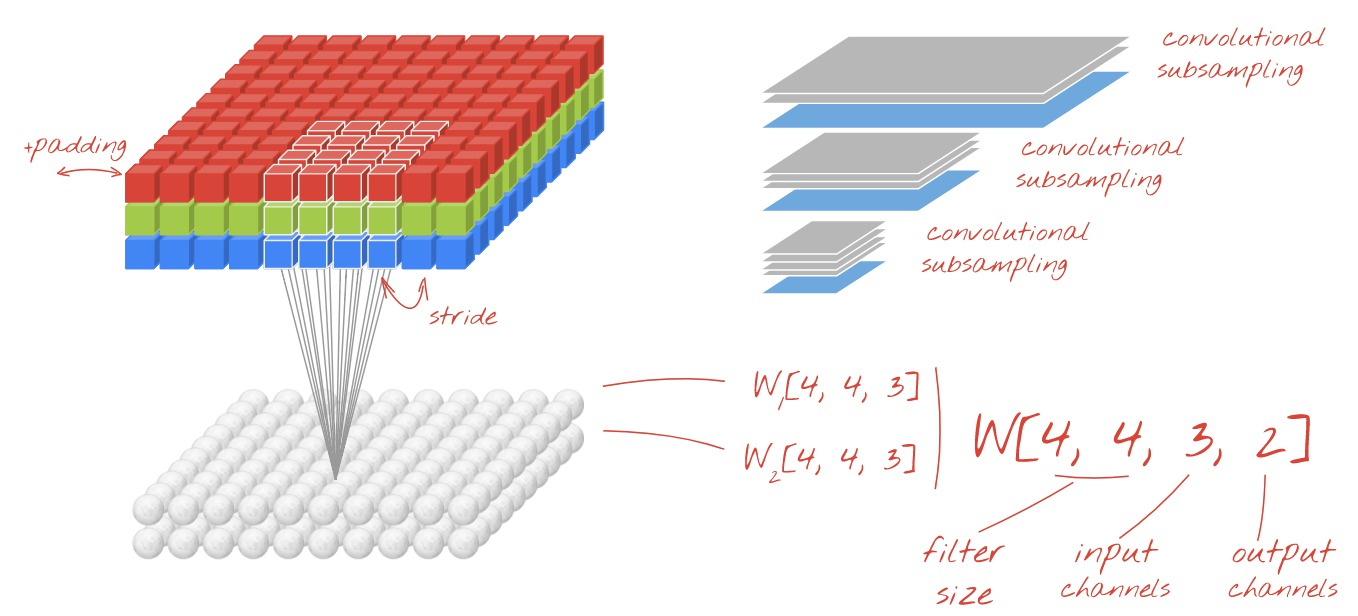

In [5]:
Image(filename='local/imgs/conv1.jpg', width=800)

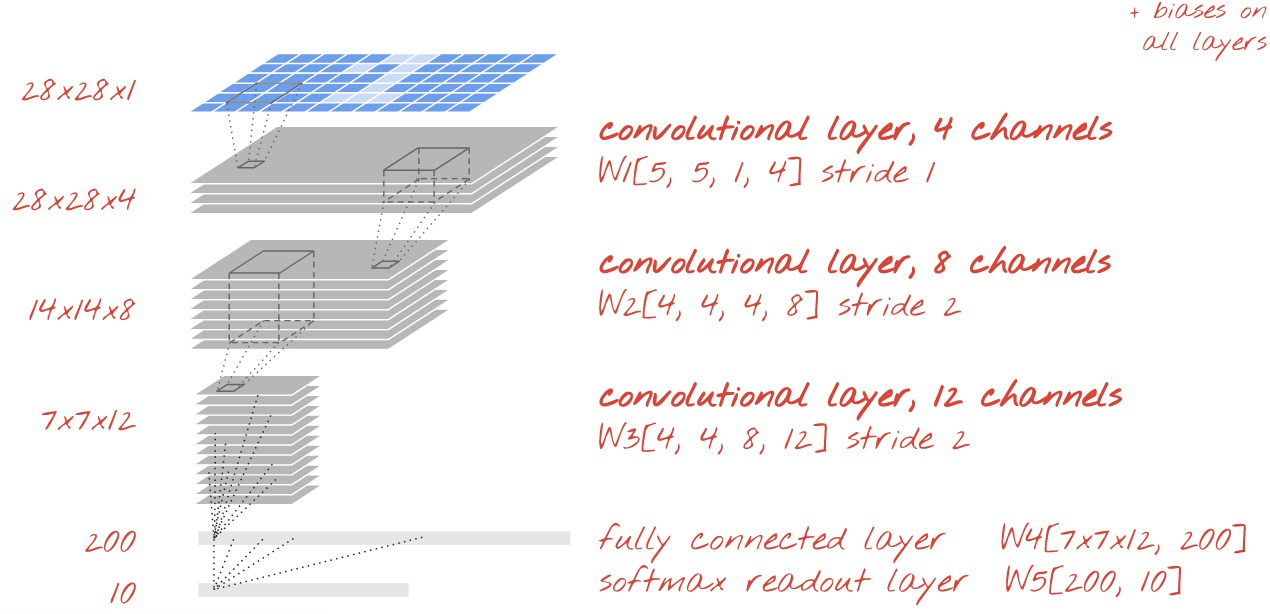

In [6]:
Image(filename='local/imgs/conv2.jpg', width=800)

otros ejemplos de filtros de primer nivel

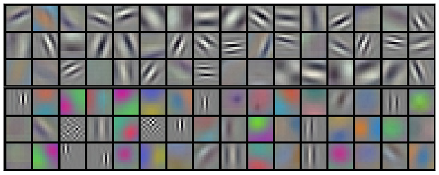

In [7]:
Image(filename='local/imgs/cnn_features2.png', width=600)

We have a small image dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), where each image size is **32x32x3**.

In [8]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [9]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

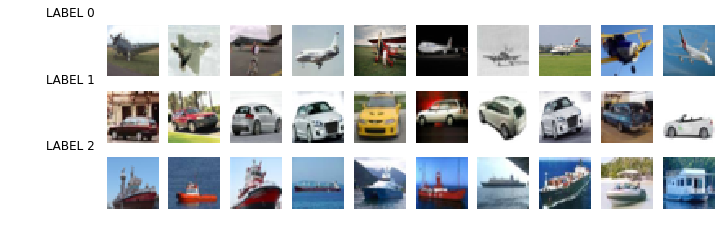

In [10]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [11]:
print (np.min(x_cifar), np.max(x_cifar))

0.0 1.0


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print ("\ndistribution of train classes")
print (pd.Series(y_train).value_counts())
print ("\ndistribution of test classes")
print (pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    778
0    750
1    725
dtype: int64

distribution of test classes
0    255
1    249
2    247
dtype: int64


build a Keras model

In [14]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [15]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_A(num_classes)

using 3 classes


observe the weights initialized and their weights

In [16]:
weights = model.get_weights()
for i in weights:
    print (i.shape)

(3, 3, 3, 15)
(15,)
(15360, 16)
(16,)
(16, 3)
(3,)


we keep the filters on the first layer to later compare them with the same filters after training.

In [17]:
initial_w0 = model.get_weights()[0].copy()

In [18]:
y_test.shape, y_train.shape, x_test.shape, x_train.shape

((751,), (2253,), (751, 32, 32, 3), (2253, 32, 32, 3))

In [19]:
num_classes = len(np.unique(y_cifar))

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


observe the shapes of model weights obtained above and try to see how they are related to the **output shape** and the **number of parameters**

In [20]:
model = get_conv_model_A(num_classes)
model.summary()

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 15)        420       
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                245776    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output_1 (Dense)             (None, 3)                 51        
Total params: 246,247
Trainable params: 246,247
Non-trainable params: 0
______________________________________________________

In [21]:
train(model, batch_size=32, epochs=10, model_name="model_A")

Train on 2253 samples, validate on 751 samples
Epoch 1/10
2253/2253 [==============================] - 1s 490us/step - loss: 0.9741 - acc: 0.5109 - val_loss: 0.8331 - val_acc: 0.6498
Epoch 2/10
2253/2253 [==============================] - 1s 430us/step - loss: 0.8445 - acc: 0.6130 - val_loss: 0.7991 - val_acc: 0.6618
Epoch 3/10
2253/2253 [==============================] - 1s 465us/step - loss: 0.7801 - acc: 0.6338 - val_loss: 0.7409 - val_acc: 0.6804
Epoch 4/10
2253/2253 [==============================] - 1s 371us/step - loss: 0.7336 - acc: 0.6755 - val_loss: 0.7352 - val_acc: 0.6818
Epoch 5/10
2253/2253 [==============================] - 1s 486us/step - loss: 0.7217 - acc: 0.6826 - val_loss: 0.6991 - val_acc: 0.7071
Epoch 6/10
2253/2253 [==============================] - 1s 538us/step - loss: 0.6801 - acc: 0.7057 - val_loss: 0.6940 - val_acc: 0.6991
Epoch 7/10
2253/2253 [==============================] - 1s 383us/step - loss: 0.6133 - acc: 0.7266 - val_loss: 0.6788 - val_acc: 0.7044
E

{'acc': 0.7270306261496918, 'loss': 0.6470887158586881}

Normalized confusion matrix
[[0.69411765 0.16862745 0.1372549 ]
 [0.04016064 0.85140562 0.10843373]
 [0.22267206 0.1417004  0.63562753]]


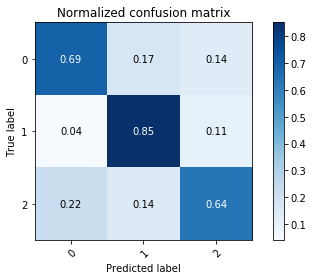

In [22]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

observe the outp in tensorboard

    tensorboard --logdir logs

first layer filters before training


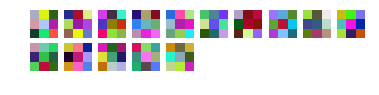

In [24]:
mlutils.display_imgs(initial_w0)

and after training

(3, 3, 3, 15)


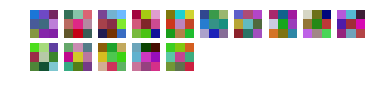

In [25]:
w0 = model.get_weights()[0]
print (w0.shape)
mlutils.display_imgs(w0)

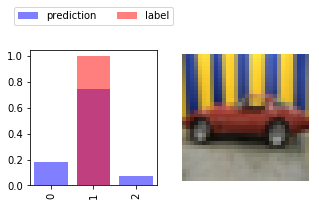

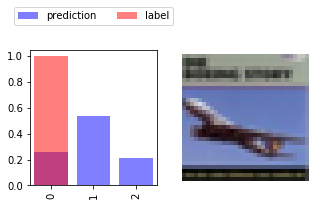

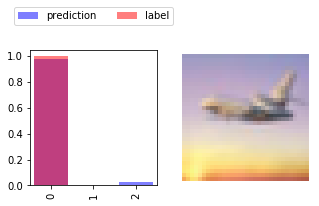

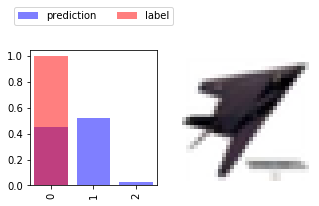

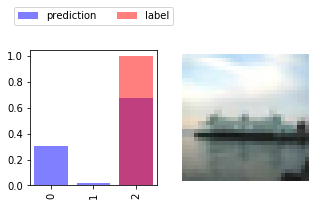

In [26]:
idxs = np.random.permutation(len(x_test))[:5]
preds = model.predict(x_test[idxs])
mlutils.show_preds(x_test[idxs],y_test[idxs], preds)

### Let's try a more complex network


In [27]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(5,5), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(5,5), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [28]:
model = get_conv_model_B(num_classes)
model.summary()
train(model, batch_size=32, epochs=10, model_name="model_B")

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 15)        1140      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 60)        22560     
_________________________________________________________________
flatten (Flatten)            (None, 6000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                96016     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0    

{'acc': 0.7536617846844517, 'loss': 0.5843058094362444}

(5, 5, 3, 15)


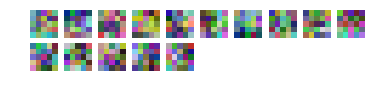

In [29]:
w0 = model.get_weights()[0]
print (w0.shape)
mlutils.display_imgs(w0)

### or with larger filters

In [30]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [31]:
model = get_conv_model_C(num_classes)
model.summary()
train(model, batch_size=32, epochs=10, model_name="model_C")

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0    

{'acc': 0.6790945410093518, 'loss': 0.7095216961103813}

(11, 11, 3, 96)


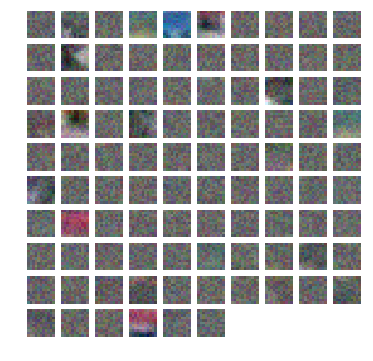

In [32]:
w0 = model.get_weights()[0]
print (w0.shape)
mlutils.display_imgs(w0)

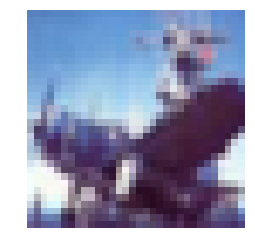

In [33]:
i = np.random.randint(len(x_test))
plt.imshow(x_test[i])
plt.axis("off");

In [34]:
acts = mlutils.get_activations(model, x_test[i:i+1])["conv2d/Relu:0"][0]

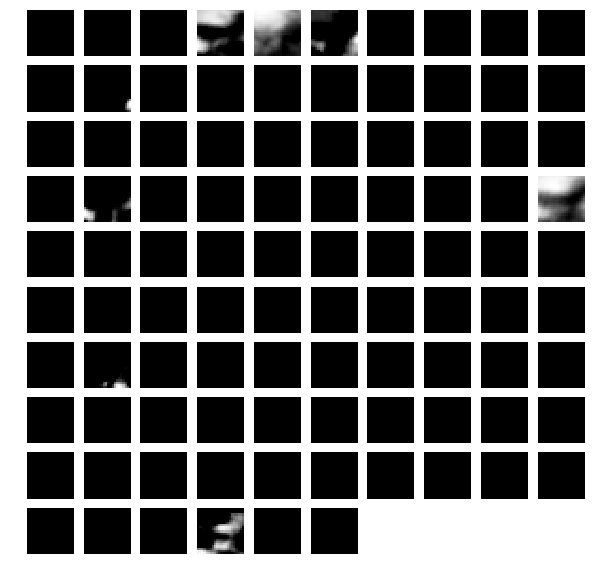

In [35]:
plt.figure(figsize=(10,10))
for i in range(acts.shape[-1]):
    plt.subplot(10,10,i+1)
    plt.imshow(acts[:,:,i], cmap=plt.cm.Greys_r )
    plt.axis("off")

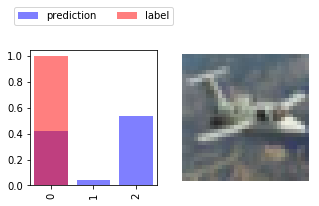

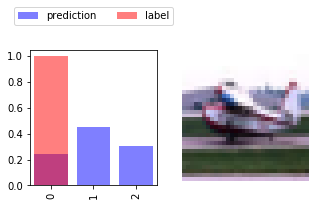

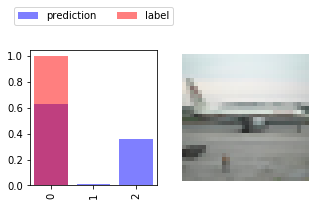

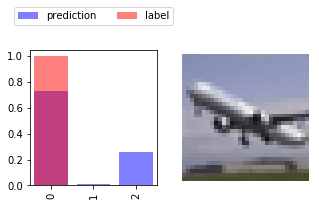

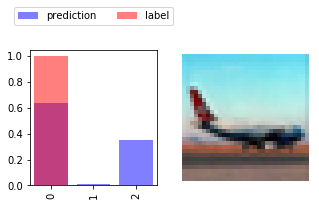

In [36]:
idxs = np.random.permutation(len(x_test))[:5]
preds = model.predict(x_test[idxs])
mlutils.show_preds(x_test[idxs],y_test[idxs], preds)

see 

- https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
- https://deepdreamgenerator.com/  

**Class activation maps**
https://jacobgil.github.io/deeplearning/class-activation-maps